In [ ]:
import os

# Configurar directorio de trabajo
target_dir = os.getcwd() if 'cnn-cards' in os.getcwd().lower() else './CNN-Cards'

if os.path.isdir(target_dir):
    os.chdir(target_dir)
print(f'Directorio actual: {os.getcwd()}')

DATA_PATH = './Datasets/Cards/'

Directorio actual: /tf/CNN-Cards


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import regularizers
from vit_keras import vit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Global variables
SIZE = 224
CLASSES = 53
EPOCHS = 10
PATIENCE_ES = 25
BATCH_SIZE = 16

path_models = 'Models'
path_results = 'Results'

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU disponible: {tf.config.list_physical_devices("GPU")}')

2025-12-04 22:47:58.168844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-04 22:47:58.169193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-04 22:47:58.241605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

TensorFlow version: 2.15.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Cargar datos con Data Augmentation agresiva

In [7]:
# Data augmentation agresiva para ViT
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=(0.9, 1.1)
)

valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

train_dataset = train_generator.flow_from_directory(
    train_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataset = valid_generator.flow_from_directory(
    valid_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = test_generator.flow_from_directory(
    test_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 7695 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [8]:
# Listar clases y sus labels desde el generador de entrenamiento
class_indices = train_dataset.class_indices

# Crear DataFrame ordenado por label
df_labels = pd.DataFrame(list(class_indices.items()), columns=['class', 'label']).sort_values('label').reset_index(drop=True)

# Mostrar en pantalla y guardar en Results
print(df_labels.to_string(index=False))

os.makedirs(path_results, exist_ok=True)
csv_path = os.path.join(path_results, 'class_labels.csv')
df_labels.to_csv(csv_path, index=False)
print(f'\nMapping guardado en: {csv_path}')

            class  label
     ace of clubs      0
  ace of diamonds      1
    ace of hearts      2
    ace of spades      3
   eight of clubs      4
eight of diamonds      5
  eight of hearts      6
  eight of spades      7
    five of clubs      8
 five of diamonds      9
   five of hearts     10
   five of spades     11
    four of clubs     12
 four of diamonds     13
   four of hearts     14
   four of spades     15
    jack of clubs     16
 jack of diamonds     17
   jack of hearts     18
   jack of spades     19
            joker     20
    king of clubs     21
 king of diamonds     22
   king of hearts     23
   king of spades     24
    nine of clubs     25
 nine of diamonds     26
   nine of hearts     27
   nine of spades     28
   queen of clubs     29
queen of diamonds     30
  queen of hearts     31
  queen of spades     32
   seven of clubs     33
seven of diamonds     34
  seven of hearts     35
  seven of spades     36
     six of clubs     37
  six of diamonds     38


## Cargar modelo base y reconstruir con regularizacion

In [9]:
# Cargar modelo pre-entrenado para obtener accuracy de referencia
from vit_keras import vit, layers as vit_layers

# Obtener TODOS los custom objects del modulo vit_keras dinamicamente
custom_objects = {}
for name_obj in dir(vit_layers):
    obj = getattr(vit_layers, name_obj)
    if isinstance(obj, type):
        custom_objects[name_obj] = obj

for name_obj in dir(vit):
    obj = getattr(vit, name_obj)
    if isinstance(obj, type):
        custom_objects[name_obj] = obj

print(f"Custom objects registrados: {list(custom_objects.keys())}")

# Intentar cargar el modelo existente
try:
    vit_pretrained = tf.keras.models.load_model(
        'Models/ViT_B16_2.h5', 
        custom_objects=custom_objects,
        compile=False
    )
    print(f'Modelo ViT_B16_2 cargado correctamente.')
    vit_pretrained.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    _, acc_original = vit_pretrained.evaluate(test_dataset, verbose=0)
    print(f'Accuracy original: {acc_original:.4f}')
except Exception as e:
    print(f'Error cargando modelo: {e}')
    print('Usando valor de referencia conocido...')
    acc_original = 0.91
    vit_pretrained = None

Custom objects registrados: ['AddPositionEmbs', 'ClassToken', 'MultiHeadSelfAttention', 'TransformerBlock', 'ConfigDict']
Modelo ViT_B16_2 cargado correctamente.
Accuracy original: 0.9245


In [10]:
# Construir modelo mejorado partiendo de ViT_B16_2 (si se cargo)
if 'vit_pretrained' in locals() and vit_pretrained is not None:
    print("Usando modelo ViT_B16_2 como base (partiendo de accuracy ~0.91)...")
    
    # Descongelar mas capas para fine-tuning adicional
    for layer in vit_pretrained.layers[:-10]:
        layer.trainable = False
    for layer in vit_pretrained.layers[-10:]:
        layer.trainable = True
    
    vit_improved = vit_pretrained
    print("Modelo base cargado con pesos existentes.")
    
else:
    print("Construyendo modelo desde ImageNet (pesos de ViT_B16_2 no disponibles)...")
    
    # Base ViT desde ImageNet
    base_vit = vit.vit_b16(image_size=SIZE, include_top=False, pretrained_top=False, pretrained=True)

    # Descongelar ultimas 5 capas del transformer
    for layer in base_vit.layers[:-5]:
        layer.trainable = False
    for layer in base_vit.layers[-5:]:
        layer.trainable = True

    # Arquitectura mejorada con regularizacion
    inputs = tf.keras.layers.Input(shape=(SIZE, SIZE, 3))
    x = base_vit(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(CLASSES, activation='softmax')(x)

    vit_improved = tf.keras.Model(inputs=inputs, outputs=outputs)

vit_improved.summary()
print(f'\nCapas entrenables: {sum([1 for l in vit_improved.layers if l.trainable])}')

Usando modelo ViT_B16_2 como base (partiendo de accuracy ~0.91)...
Modelo base cargado con pesos existentes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               98432     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 53)                3445      
                                                                 
Total params: 85908789 (327.72 MB)
Trainable params: 85908789 (327.72 MB)
Non

In [11]:
# Contar parametros entrenables
trainable_params = np.sum([np.prod(v.shape) for v in vit_improved.trainable_variables])
non_trainable_params = np.sum([np.prod(v.shape) for v in vit_improved.non_trainable_variables])
print(f'Parametros entrenables: {trainable_params:,}')
print(f'Parametros no entrenables: {non_trainable_params:,}')

Parametros entrenables: 85,908,789
Parametros no entrenables: 0.0


## Configurar callbacks y entrenar

In [12]:
name = 'ViT_B16_3'

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=PATIENCE_ES,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=f'logs/{name}',
    histogram_freq=1
)

callbacks_list = [checkpoint, early_stop, reduce_lr, tensorboard]

In [13]:
# Compilar con learning rate bajo
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

vit_improved.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [14]:
# Entrenar
history = vit_improved.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/10


I0000 00:00:1764888880.046868     182 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


481/481 [==============================] - ETA: 0s - loss: 0.3206 - accuracy: 0.8997 - precision: 0.9354 - recall: 0.8767
Epoch 1: val_accuracy improved from -inf to 0.96981, saving model to Models/ViT_B16_3.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


481/481 [==============================] - 255s 476ms/step - loss: 0.3206 - accuracy: 0.8997 - precision: 0.9354 - recall: 0.8767 - val_loss: 0.0998 - val_accuracy: 0.9698 - val_precision: 0.9771 - val_recall: 0.9660 - lr: 5.0000e-05
Epoch 2/10
481/481 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.9188 - precision: 0.9443 - recall: 0.8992
Epoch 2: val_accuracy improved from 0.96981 to 0.98113, saving model to Models/ViT_B16_3.h5
481/481 [==============================] - 256s 532ms/step - loss: 0.2616 - accuracy: 0.9188 - precision: 0.9443 - recall: 0.8992 - val_loss: 0.0908 - val_accuracy: 0.9811 - val_precision: 0.9848 - val_recall: 0.9774 - lr: 5.0000e-05
Epoch 3/10
481/481 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.9289 - precision: 0.9525 - recall: 0.9114
Epoch 3: val_accuracy did not improve from 0.98113
481/481 [==============================] - 250s 519ms/step - loss: 0.2272 - accuracy: 0.9289 - precision: 0.9525 - recall: 

## Visualizar resultados

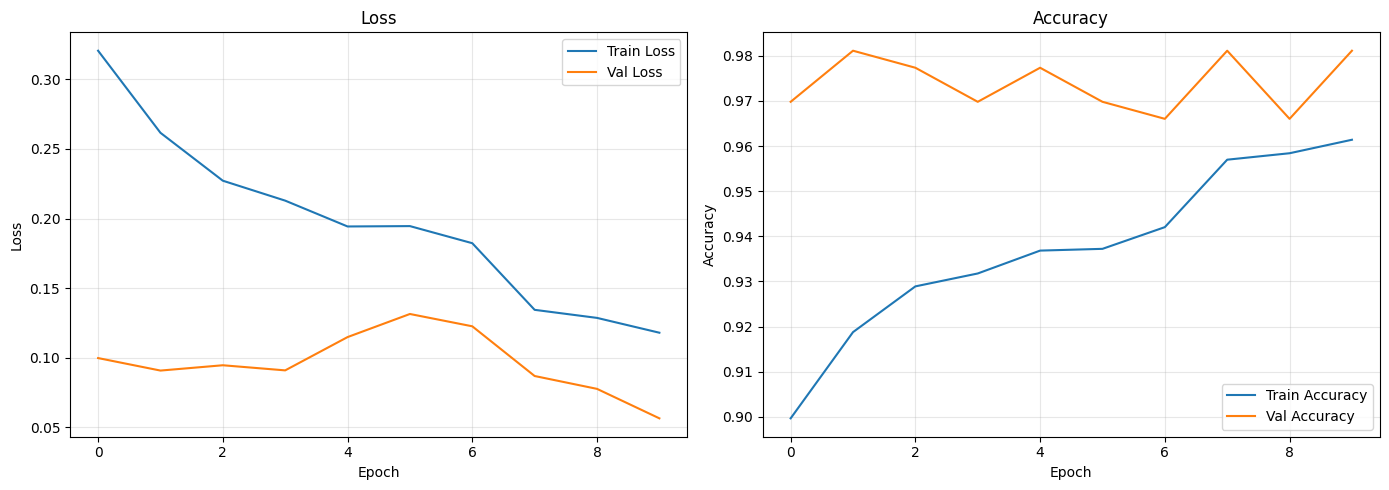

In [15]:
def plot_and_save(h, dir, name):
    history_df = pd.DataFrame(h.history)
    history_df['epoch'] = list(range(len(history_df)))
    history_df.to_csv(os.path.join(dir, name + '.csv'), header=True, index=False)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history_df['epoch'], history_df['loss'], label='Train Loss')
    axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history_df['epoch'], history_df['accuracy'], label='Train Accuracy')
    axes[1].plot(history_df['epoch'], history_df['val_accuracy'], label='Val Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(dir, name + '_curves.png'), dpi=150)
    plt.show()

plot_and_save(history, path_results, name)

## Evaluacion en Test Set

In [16]:
# Cargar mejor modelo (necesita custom_objects para capas de vit_keras)
from vit_keras import vit, layers as vit_layers

# Obtener TODOS los custom objects del modulo vit_keras dinamicamente
custom_objects = {}
for name_obj in dir(vit_layers):
    obj = getattr(vit_layers, name_obj)
    if isinstance(obj, type):
        custom_objects[name_obj] = obj

for name_obj in dir(vit):
    obj = getattr(vit, name_obj)
    if isinstance(obj, type):
        custom_objects[name_obj] = obj

best_model = tf.keras.models.load_model(
    os.path.join(path_models, name + '.h5'),
    custom_objects=custom_objects
)

# Evaluar
_, acc_improved, _, _ = best_model.evaluate(test_dataset)

print(f'\n=== Comparacion de resultados ===')
print(f'Accuracy original (ViT_B16_2): {acc_original:.4f}')
print(f'Accuracy mejorado (ViT_B16_3): {acc_improved:.4f}')
print(f'Mejora: {(acc_improved - acc_original)*100:.2f}%')

17/17 [==============================] - 5s 153ms/step - loss: 0.0941 - accuracy: 0.9698 - precision: 0.9772 - recall: 0.9698

=== Comparacion de resultados ===
Accuracy original (ViT_B16_2): 0.9245
Accuracy mejorado (ViT_B16_3): 0.9698
Mejora: 4.53%


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def show_report(model, dataframe):
    labels = dataframe.class_indices
    true_labels = dataframe.labels
    pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)
    keys_array = np.array(list(labels.keys()))
    true_text = [keys_array[value] for value in true_labels]
    pred_text = [keys_array[value] for value in pred_labels]
    print(classification_report(true_text, pred_text))

def show_matrix(model, dataframe):
    labels = dataframe.class_indices
    true_labels = dataframe.labels
    pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)
    keys_array = np.array(list(labels.keys()))
    true_text = [keys_array[value] for value in true_labels]
    pred_text = [keys_array[value] for value in pred_labels]
    cf = confusion_matrix(true_text, pred_text, labels=keys_array)
    fig, ax = plt.subplots(figsize=(20, 20))
    sns.heatmap(cf, annot=True, fmt='d', square=True, cbar=True,
                annot_kws={'fontsize': 8}, cmap=plt.cm.Blues, 
                xticklabels=keys_array, yticklabels=keys_array, ax=ax)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_title(f'Confusion Matrix - {name}', fontsize=14)
    plt.xticks(rotation=90, fontsize=7)
    plt.yticks(fontsize=7)
    plt.tight_layout()
    plt.show()

show_report(best_model, test_dataset)

                   precision    recall  f1-score   support

     ace of clubs       1.00      1.00      1.00         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       1.00      1.00      1.00         5
    ace of spades       1.00      1.00      1.00         5
   eight of clubs       0.83      1.00      0.91         5
eight of diamonds       1.00      1.00      1.00         5
  eight of hearts       1.00      1.00      1.00         5
  eight of spades       1.00      1.00      1.00         5
    five of clubs       1.00      0.80      0.89         5
 five of diamonds       1.00      1.00      1.00         5
   five of hearts       1.00      1.00      1.00         5
   five of spades       1.00      1.00      1.00         5
    four of clubs       1.00      1.00      1.00         5
 four of diamonds       1.00      1.00      1.00         5
   four of hearts       1.00      1.00      1.00         5
   four of spades       1.00      1.00      1.00       

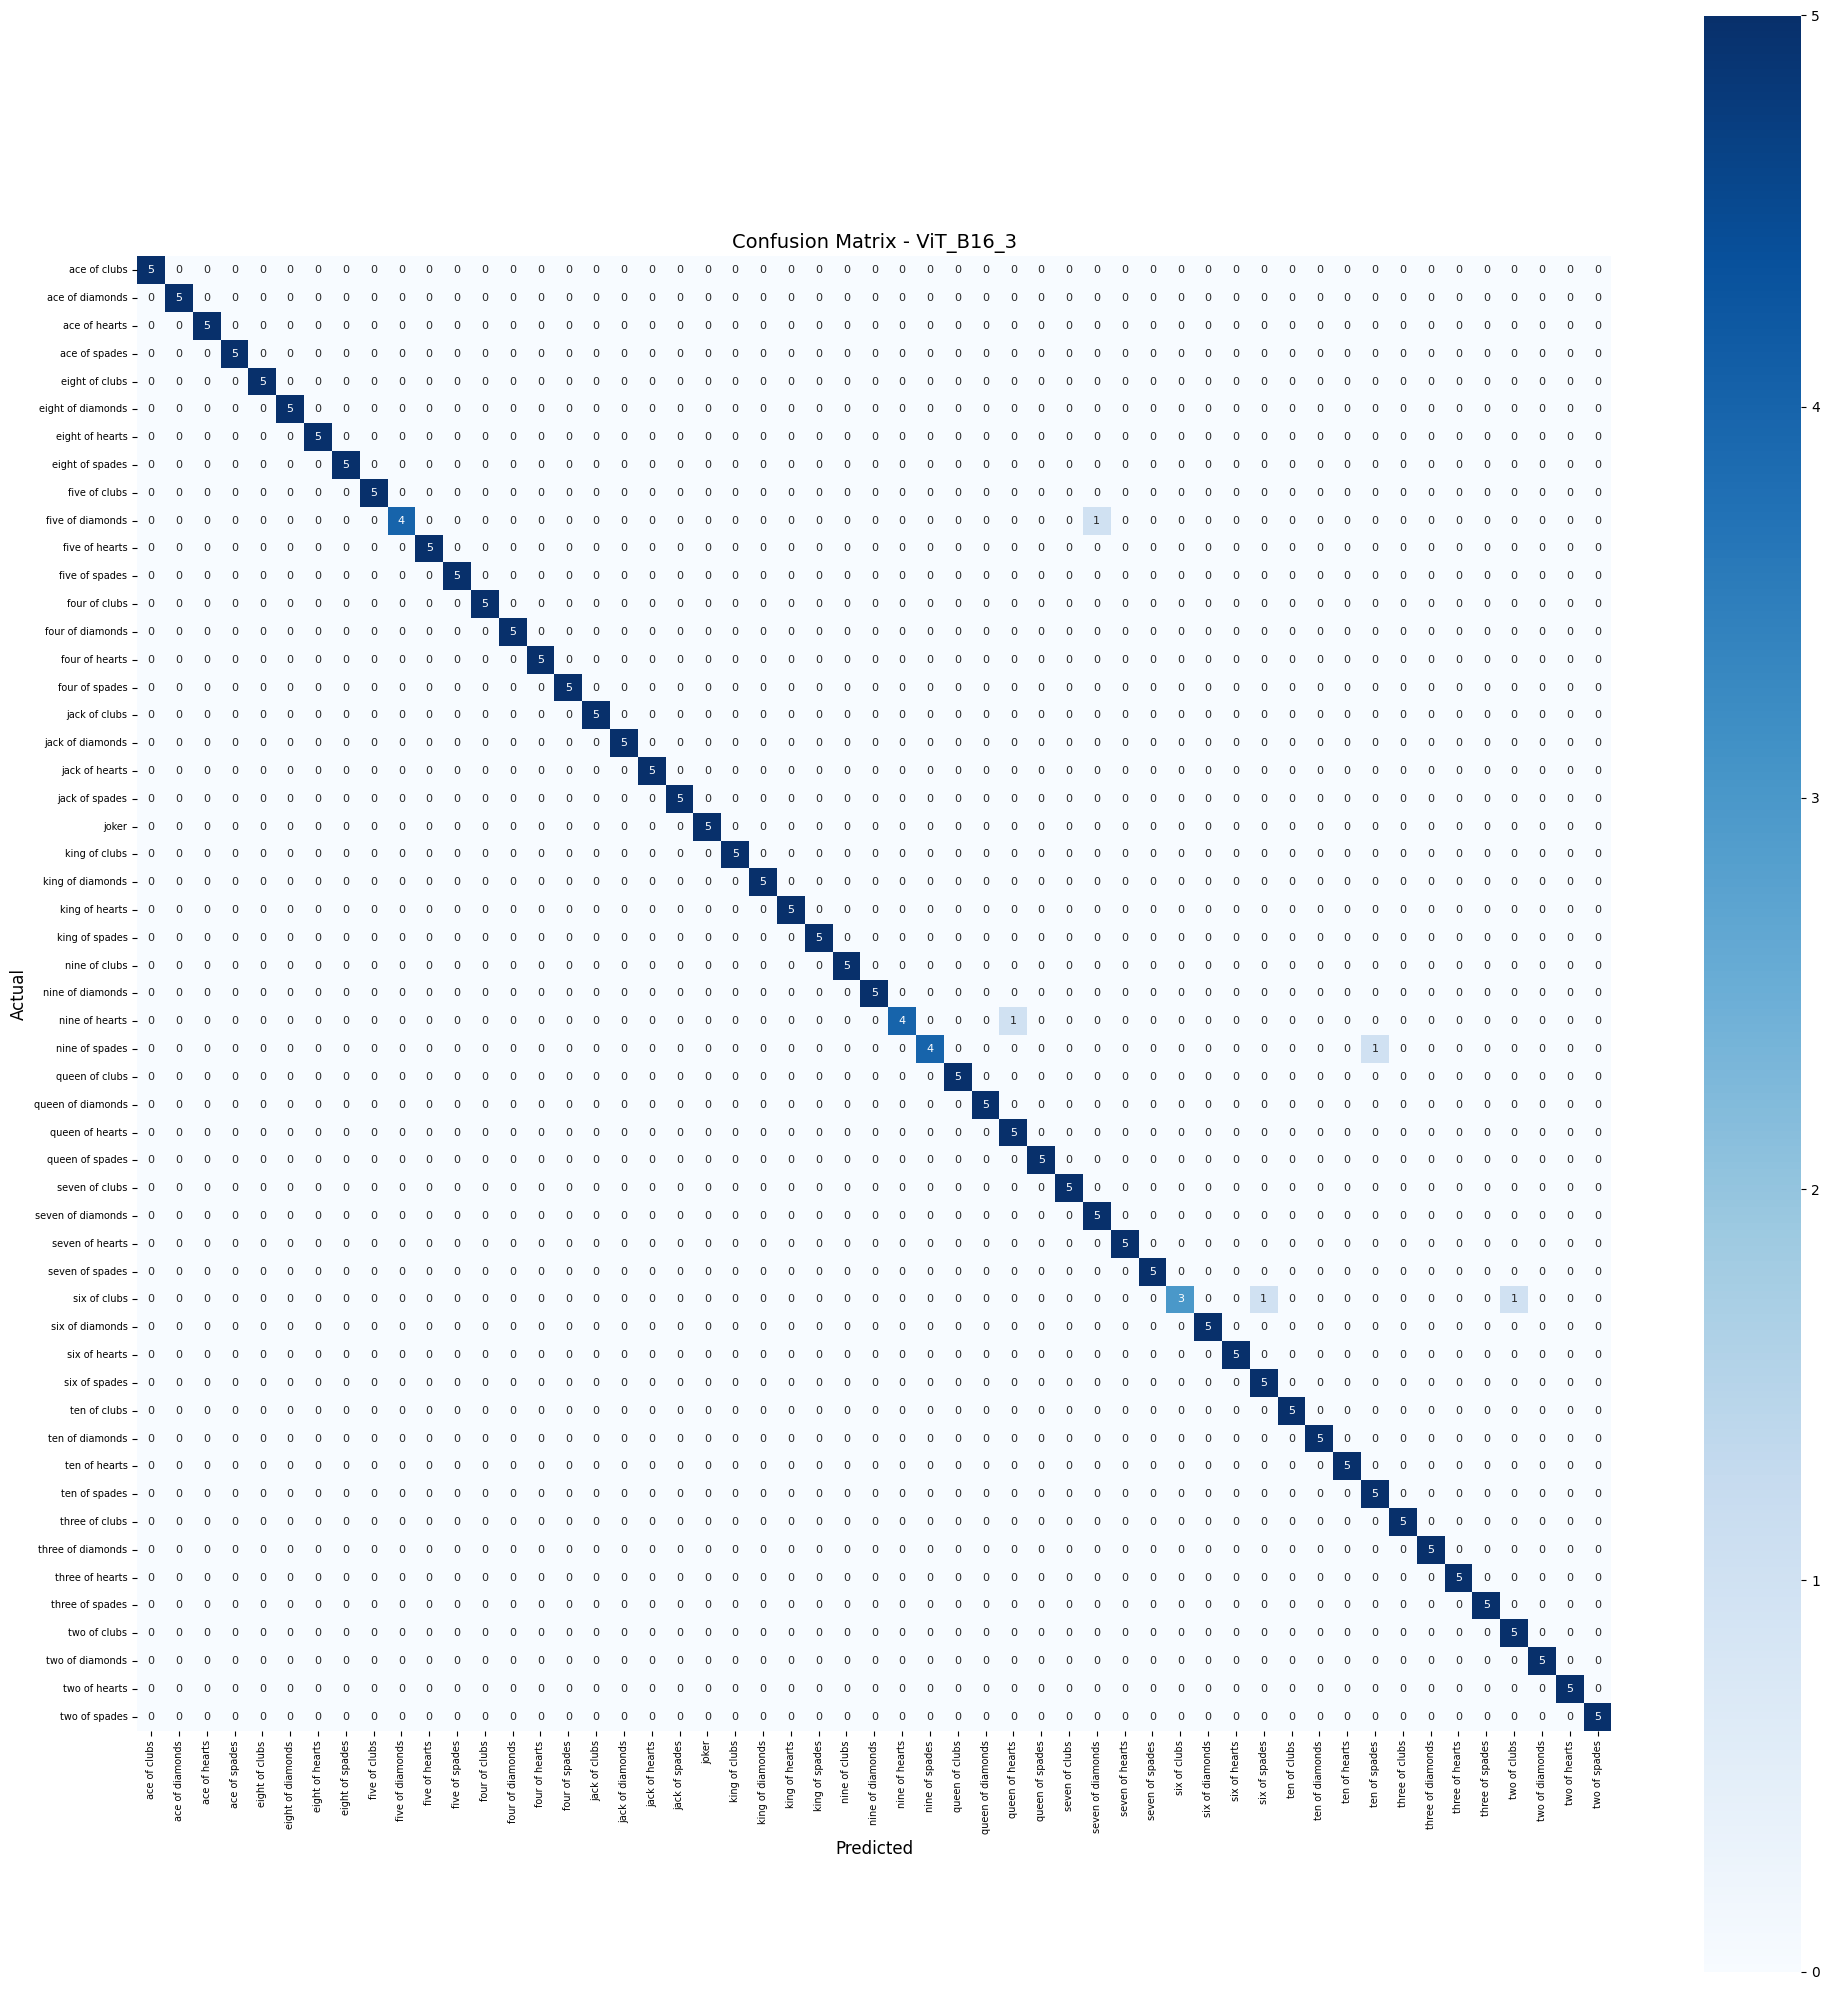

In [18]:
show_matrix(best_model, test_dataset)